In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install scikit-plot

In [3]:
# import all libraries
import os
import numpy as np
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot
from sklearn.metrics import roc_curve, auc

%cd '/content/drive/My Drive/GitHub Repositories/COVID-19'

/content/drive/My Drive/GitHub Repositories/COVID-19


In [0]:
dataDir = './datasets/dataset 01/Numpy Files'
train_x = np.load(dataDir+'/train_images.npy')
train_y = np.load(dataDir+'/train_labels.npy')
test_x = np.load(dataDir+'/test_images.npy')
test_y = np.load(dataDir+'/test_labels.npy')

print('Training Images: {} | Test Images: {}'.format(train_x.shape, test_x.shape))
print('Training Labels: {} | Test Labels: {}'.format(train_y.shape, test_y.shape))

# Data Normalization

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

train_x/=255.0
test_x/=255.0

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))


Training Images: (5310, 224, 224, 3) | Test Images: (639, 224, 224, 3)
Training Labels: (5310,) | Test Labels: (639,)
Train: 0.0 , 255.0 | Test: 0.0 , 255.0
Train: 0.0 , 1.0 | Test: 0.0 , 1.0


In [0]:
# Class Mapping 
print('0:Normal | 1:Bacteria | 2:Viral | 3:COVID-19')

# Distribution of images in each class for Training-set
print(Counter(train_y))

# Distribution of images in each class for Test-set
print(Counter(test_y))

#Make Labels Categorical
train_y_oneHot = tf.one_hot(train_y, depth=4) 
test_y_oneHot = tf.one_hot(test_y, depth=4)

print('Training Labels: {} | Test Labels: {}'.format(train_y_oneHot.shape, test_y_oneHot.shape))


0:Normal | 1:Bacteria | 2:Viral | 3:COVID-19
Counter({1: 2540, 2: 1355, 0: 1349, 3: 66})
Counter({1: 246, 0: 234, 2: 149, 3: 10})
Training Labels: (5310, 4) | Test Labels: (639, 4)


In [0]:
# initialize the training data augmentation object
trainAug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15, fill_mode="nearest")

def VGG16_Model():
  # load the VGG16 network, ensuring the head FC layer sets are left off
  baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
  # construct the head of the model that will be placed on top of the the base model
  output = baseModel.output
  output = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(output)
  output = tf.keras.layers.Flatten(name="flatten")(output)
  output = tf.keras.layers.Dense(256, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(4, activation="softmax")(output)
  # place the head FC model on top of the base model (this will become the actual model we will train)
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model

model = VGG16_Model()
# compile our model
print("[INFO] compiling model...")
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 40
BATCHSIZE = 32 
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
print(model.summary())

58892288/58889256 [==============================] - 0s 0us/step
[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________

In [6]:
modelPath = './saved Models/Pretrained VGG16'
if not os.path.exists(modelPath):
  os.makedirs(modelPath)
  print('Model Directory Created')
else:
  print('Model Directory Already Exists')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelPath+'/vgg16-best-model.h5', monitor='val_categorical_accuracy',
                                                      verbose=1, save_best_only=True, mode='auto')

STEP_TRAIN = len(train_x) // BATCHSIZE
STEP_TEST = len(test_x) // BATCHSIZE
modelHistory = model.fit(trainAug.flow(train_x, train_y_oneHot, batch_size=BATCHSIZE), epochs=EPOCHS, verbose=1, callbacks=[model_checkpoint],
                         validation_data=(test_x, test_y_oneHot), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST)
tf.keras.models.save_model(model, modelPath+'/vgg16-model.h5', overwrite=True, include_optimizer=True, save_format=None,
                           signatures=None, options=None)

Model Directory Created
Epoch 1/40
165/165 [==============================] - ETA: 0s - loss: 0.8848 - categorical_accuracy: 0.6127 - auc: 0.8586
Epoch 00001: val_categorical_accuracy improved from -inf to 0.56495, saving model to ./saved Models/Pretrained VGG16/vgg16-best-model.h5
165/165 [==============================] - 53s 323ms/step - loss: 0.8848 - categorical_accuracy: 0.6127 - auc: 0.8586 - val_loss: 0.9559 - val_categorical_accuracy: 0.5649 - val_auc: 0.8510
Epoch 2/40
165/165 [==============================] - ETA: 0s - loss: 0.7115 - categorical_accuracy: 0.6993 - auc: 0.9086
Epoch 00002: val_categorical_accuracy improved from 0.56495 to 0.72613, saving model to ./saved Models/Pretrained VGG16/vgg16-best-model.h5
165/165 [==============================] - 52s 317ms/step - loss: 0.7115 - categorical_accuracy: 0.6993 - auc: 0.9086 - val_loss: 0.7731 - val_categorical_accuracy: 0.7261 - val_auc: 0.9041
Epoch 3/40
165/165 [==============================] - ETA: 0s - loss: 0.663

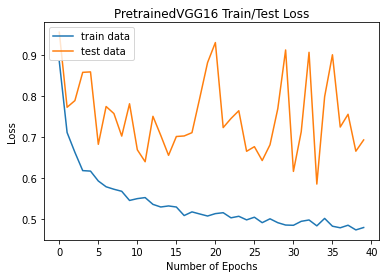

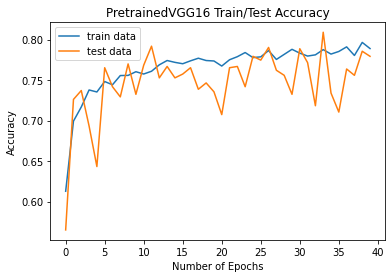

In [8]:
import matplotlib.pyplot as plt
losshistoryPath = './Train-Test History/Loss'
acchistoryPath = './Train-Test History/Accuracy'
if not os.path.exists(losshistoryPath) or not os.path.exists(acchistoryPath):
  os.makedirs(losshistoryPath)
  os.makedirs(acchistoryPath)
  
# Plot history: Loss
plt.plot(modelHistory.history['loss'], label='train data')
plt.plot(modelHistory.history['val_loss'], label='test data')
plt.title('PretrainedVGG16 Train/Test Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('./Train-Test History/Loss/VGG16-loss-Graph.png', bbox_inches = "tight")
plt.show()

# Plot history: Accuracy
plt.plot(modelHistory.history['categorical_accuracy'], label='train data')
plt.plot(modelHistory.history['val_categorical_accuracy'], label='test data')
plt.title('PretrainedVGG16 Train/Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('./Train-Test History/Accuracy/VGG16-Accuracy-Graph.png', bbox_inches = "tight")
plt.show()

In [62]:
# Evaluate the Best Saved Model
bestModel = tf.keras.models.load_model('./saved Models/Pretrained VGG16/vgg16-best-model.h5')
loss, accuracy, auc = bestModel.evaluate(x=test_x, y=test_y_oneHot, batch_size=32, verbose=1)
print('Model Accuracy: {:0.2f} | Model AUC: {:0.2f} | Model Loss: {:0.4f}'.format(accuracy, auc, loss))

20/20 [==============================] - 2s 79ms/step - loss: 0.5850 - categorical_accuracy: 0.8091 - auc: 0.9453
Model Accuracy: 0.81 | Model AUC: 0.95 | Model Loss: 0.5850


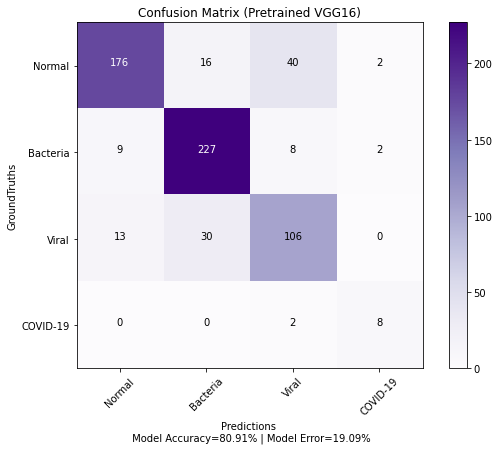

In [64]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('GroundTruths')
    plt.xlabel('Predictions \n Model Accuracy={:0.2f}% | Model Error={:0.2f}%'.format(accuracy*100, misclass*100))
    plt.savefig('./ReadMe Images/VGG16-cm.png', bbox_inches = "tight")
    plt.show()


predictions = bestModel.predict(x=test_x, batch_size=32)
predictions = tf.keras.backend.argmax(predictions, axis=-1)

cm = confusion_matrix(test_y, predictions)
classes = ['Normal', 'Bacteria', 'Viral', 'COVID-19']
plot_confusion_matrix(cm=cm, normalize = False, target_names = classes, title= "Confusion Matrix (Pretrained VGG16)")


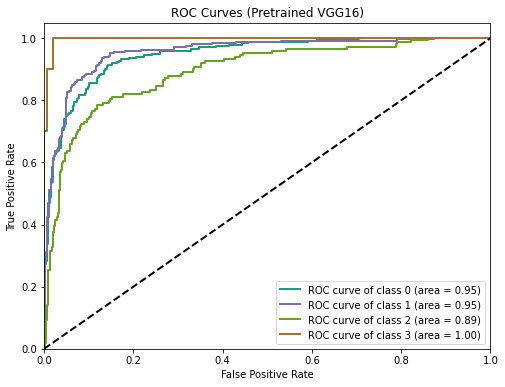

In [68]:
#Plot ROC Curve with Library
predictions = bestModel.predict(x=test_x, batch_size=32)
# One can define colormap here
# cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])
scikitplot.metrics.plot_roc(y_true=test_y, y_probas=predictions, title='ROC Curves (Pretrained VGG16)', plot_micro=False, plot_macro=False,
                            classes_to_plot=None, ax=None, figsize=(8, 6), cmap='Dark2', title_fontsize='large', text_fontsize='medium')
plt.savefig('./ReadMe Images/VGG16-roc.png', bbox_inches = "tight")
plt.show()

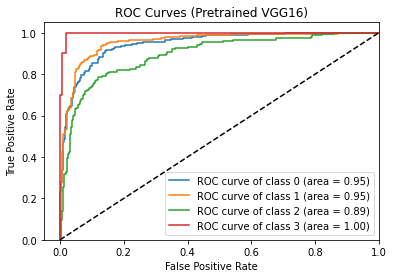

In [75]:
#Plot ROC Curve with Fuction
predictions = bestModel.predict(x=test_x, batch_size=32)
n_classes = np.uint8(test_y_oneHot).shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.uint8(test_y_oneHot)[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Pretrained VGG16)')
plt.legend(loc="lower right")
plt.show()


In [4]:
!pip install tf-keras-vis tensorflow


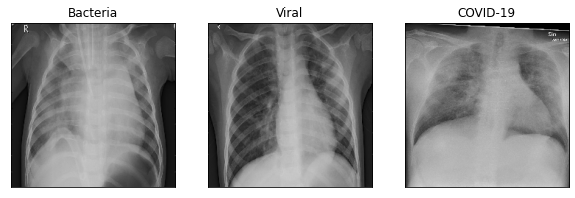

In [13]:
dataDir = './datasets/dataset 01/data/test'

bacteriaImg = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(dataDir + '/1:Bacteria/person83_bacteria_410.jpeg',
                                                                                          target_size=(224, 224)), dtype=np.float32)
bacteriaImg = np.expand_dims((bacteriaImg/255.0), axis=0)

viralImg = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(dataDir + '/2:Viral/person3_virus_15.jpeg',
                                                                                          target_size=(224, 224)), dtype=np.float32)
viralImg = np.expand_dims((viralImg/255.0), axis=0)

covidImg = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(dataDir + '/3:COVID19/covid-19-pneumonia-15-PA.jpg',
                                                                                          target_size=(224, 224)), dtype=np.float32)
covidImg = np.expand_dims((covidImg/255.0), axis=0)

images = np.concatenate([bacteriaImg, viralImg, covidImg])

titles = ['Bacteria', 'Viral', 'COVID-19']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
for i in range(images.shape[0]):
    ax[i].imshow(images[i, :, :, :])
    ax[i].set_title(titles[i])

In [14]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from matplotlib import cm

model = tf.keras.models.load_model('./saved Models/Pretrained VGG16/vgg16-model.h5')

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Saliency object
saliency = Saliency(model, model_modifier)
# Create Gradcam object
gradcam = Gradcam(model, model_modifier)

def Get_Gadcam_Map(img, loss):
  # Define loss function. cls is the output index corresponding to respective class.
  img = np.expand_dims(img, axis=0)
  # Generate heatmap with GradCAM
  cam = gradcam(loss, img)
  cam = normalize(cam)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  heatmap = np.squeeze(heatmap)
  return heatmap

def Get_Saliency_Map(img, model):
  # Define loss function. cls is the output index corresponding to respective class.
  img = np.expand_dims(img, axis=0)
  cls = np.argmax(model.predict(img))
  loss = lambda output: K.mean(output[:, cls])
  # Generate saliency map
  saliency_map = saliency(loss, img, smooth_samples=20)
  saliency_map = normalize(saliency_map)
  saliency_map = np.swapaxes(saliency_map, 0, 2)
  return loss, saliency_map

Saliency_Output =[]
Heatmaps = []
for i in range(images.shape[0]):
  img = images[i, :, :, :]
  loss, saliency_map_ = Get_Saliency_Map(img, model)
  cam_ = Get_Gadcam_Map(img, loss)
  Heatmaps.append(cam_)
  Saliency_Output.append(saliency_map_)

Saliency_Output= np.array(Saliency_Output).reshape(-1, 224, 224, 1)
Heatmaps= np.array(Heatmaps).reshape(-1, 224, 224, 3)  


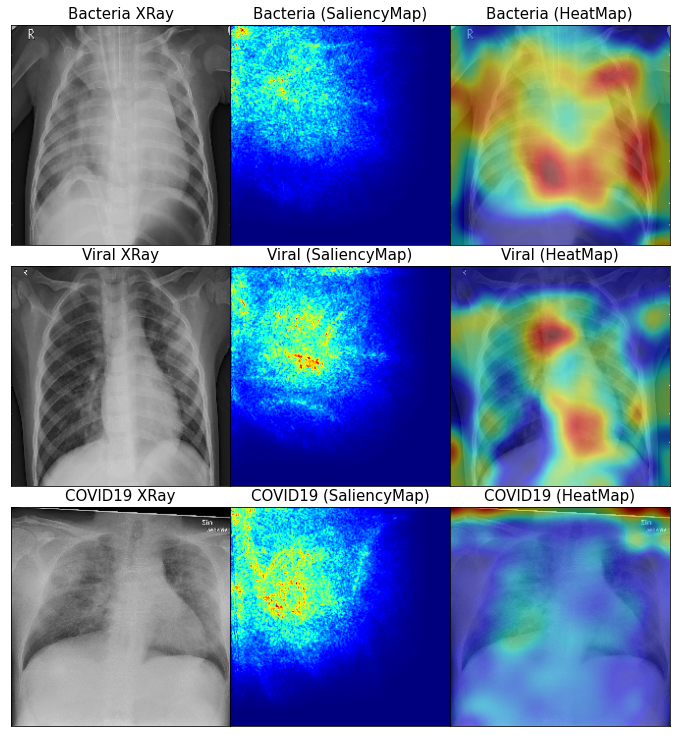

In [15]:
images_titles = ['Bacteria XRay', 'Viral XRay', 'COVID19 XRay']
saliency_titles = ['Bacteria (SaliencyMap)', 'Viral (SaliencyMap)', 'COVID19 (SaliencyMap)']
heatmap_titles = ['Bacteria (HeatMap)', 'Viral (HeatMap)', 'COVID19 (HeatMap)']

rows = 3
cols = 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(9.5, 10.5), subplot_kw={'xticks': [], 'yticks': []})
for r in range(rows):
  # plot image
  ax[r][0].imshow(images[r, :, :, :])
  ax[r][0].set_title(images_titles[r], fontsize=15)
  
  # plot saliency
  ax[r][1].imshow(Saliency_Output[r, :, :, 0], cmap='jet')
  ax[r][1].set_title(saliency_titles[r], fontsize=15)

  # plot heatmap
  ax[r][2].imshow(images[r, :, :, :])
  ax[r][2].imshow(Heatmaps[r, :, :, :], cmap='jet', alpha=0.5)
  ax[r][2].set_title(heatmap_titles[r], fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('./ReadMe Images/VGG16-visualization.png', bbox_inches = "tight")
plt.show()
plt.close() 
